In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import ClassicalRegister, QuantumRegister, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_60/1809021497.py:14: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# 3点曲げ試験の結果を学習させる
別の授業で、材料の強度を測る3点曲げ試験を行ったのですが、想定されている荷重に対して大分低い荷重で行ったので、ちょうど良い感じにノイズが発生しました。これを使ってみます。
実験では、毎秒決まった長さだけ資料片を押し下げ、その時かけている荷重を測ります。STROKEが押し下げた長さ、LOADがかけた荷重です。

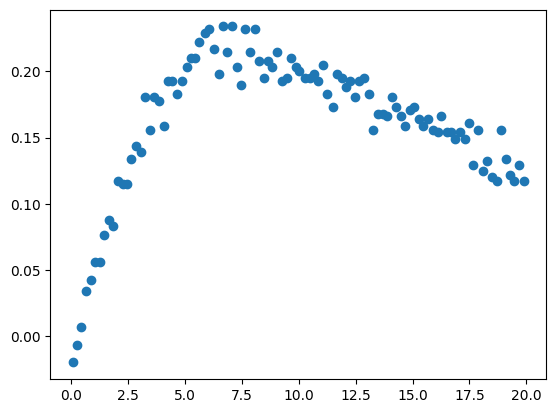

In [2]:

df = pd.read_excel('data.xlsx', sheet_name='board1', header=0)

# 時間について等間隔にn個の行を抽出
total_rows = len(df)
n = 100  # 抽出する行数
indices = np.linspace(0, total_rows - 1, n, dtype=int)
even_sample = df.iloc[indices]
load = even_sample['LOAD'].values
stroke = even_sample['STROKE'].values



plt.plot(stroke, load, "o"); plt.show()

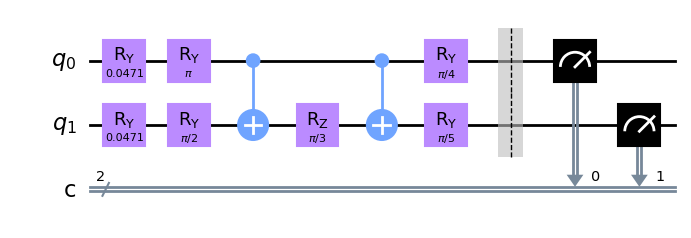

In [3]:
def input(circ, x):
#    theta = np.arcsin(2*x-1)
    theta = np.pi*x/20
    circ.ry(theta,0)
    circ.ry(theta,1)

def para_circ(circ, theta):
    circ.ry(theta[0],0)
    circ.ry(theta[1],1)
    circ.cx(0,1)
    circ.rz(theta[2],1)
    circ.cx(0,1)
    circ.ry(theta[3],0)
    circ.ry(theta[4],1)
    
def qcirc(x,theta):
    qnum = 2 # number of qubits 
    cnum = 2 # number of classical bits for the measurement

    q = QuantumRegister(2, 'q')
    c = ClassicalRegister(2, 'c')

    circ = QuantumCircuit(q, c)
    meas = QuantumCircuit(q, c)

    input(circ,x)
    para_circ(circ,theta)

    meas.barrier()
    meas.measure([0,1],[0,1])

    qc= circ.compose(meas)
    return qc

def predict(x,theta):
    qc=qcirc(x,theta)
    simulator = Aer.get_backend('qasm_simulator')
    job_sim = simulator.run(transpile(qc, simulator), shots=8192)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    n00=counts.get('00',0)
    n01=counts.get('01',0)
    n10=counts.get('10',0)
    n11=counts.get('11',0)
    a0=list(counts.values())
    ntotal=sum(a0)
    sigma0=(0*n00+1*n01+2*n10+3*n11)/ntotal/12
    return sigma0

def loss_eval(theta):
    y_pred = [predict(x,theta) for x in stroke] #内包表記
    L = ((y_pred - load)**2).mean()
    return L


qcirc(0.3, [np.pi,np.pi/2,np.pi/3,np.pi/4,np.pi/5]).draw(output='mpl')

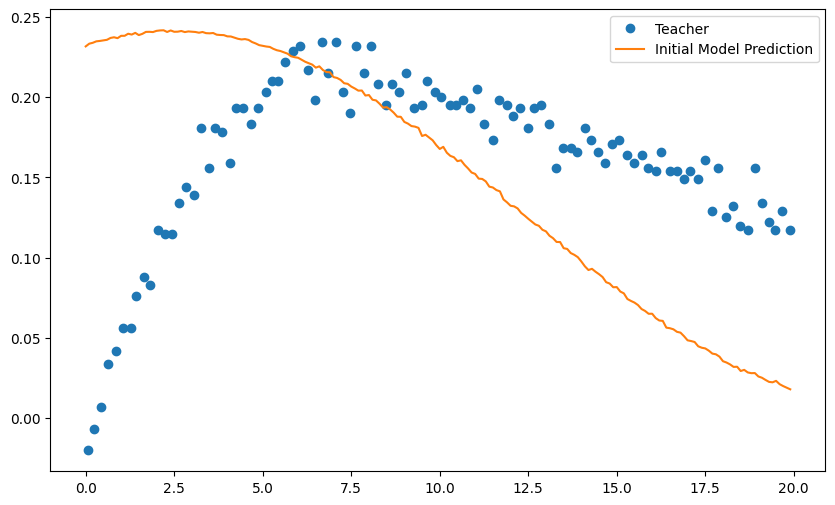

In [7]:
para_init=[2.0,2.0,3,-0.5,-0.5]

plt.figure(figsize=(10, 6))

x_min = 0
x_max = 20
xlist = np.arange(x_min, x_max, 0.1)
plt.plot(stroke, load, "o", label='Teacher')
y_init = [predict(x, para_init) for x in xlist]
plt.plot(xlist, y_init, label='Initial Model Prediction')

plt.legend()
plt.show()

In [19]:
x0=stroke[0]
y0=load[0]
qc=qcirc(x0,para_init)
qc.draw(output='mpl')
predict(x0,para_init)
loss_eval(para_init)

0.0071834623451219

In [20]:
from scipy.optimize import minimize
result = minimize(loss_eval, para_init, method='Nelder-Mead')
# 最適化後のcost_functionの値
result.fun

0.001256283049262497

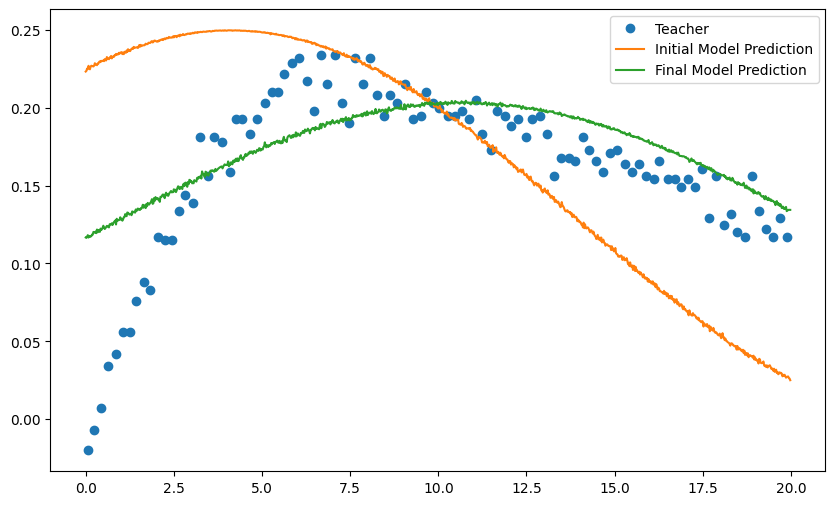

In [21]:
para_opt = result.x
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(stroke, load, "o", label='Teacher')

y_init = [predict(x, para_init) for x in xlist]
plt.plot(xlist, y_init, label='Initial Model Prediction')

# モデルの予測値
y_pred = np.array([predict(x, para_opt) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()